In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder, StandardScaler
import os
from scipy.stats import truncnorm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam

# from tensorflow.keras.utils import plot_model

In [2]:
def generate_customer_features(n):
    np.random.seed(42)
    age = np.clip(np.random.normal(40, 12, n).astype(int), 18, 70)  # Normal distribution, clipped to 18-70
    # Use truncated normal for income to avoid mode at lower bound
    lower, upper = 40000, 180000
    mu, sigma = 75000, 35000
    a, b = (lower - mu) / sigma, (upper - mu) / sigma
    income = truncnorm(a, b, loc=mu, scale=sigma).rvs(n).astype(int)
    marital_status = np.random.choice(['single', 'married', 'divorced'], n, p=[0.5, 0.4, 0.1])
    # Conversion: correlated with income, age, marital status, but target ~8%
    logits = 0.7 * (income > 65000).astype(int) + 0.5 * (age > 40).astype(int) + 0.6 * (marital_status == 'married').astype(int)
    logits = logits + np.random.normal(0, 0.5, n)
    prob = 1 / (1 + np.exp(-logits - 2.2))  # Shift to lower base rate
    conversion = np.random.binomial(1, prob)
    return pd.DataFrame({
        'user_id': np.arange(n),
        'age': age,
        'income': income,
        'marital_status': marital_status,
        'conversion': conversion.astype(int)
    })

In [3]:
# Define allowed campaigns for each channel for realistic mapping
channel_campaign_map = {
    'Email': ['Brand Awareness', 'Holiday Promo', 'Retargeting', 'Product Launch', 'Abandoned Cart', 'Loyalty Program', 'Flash Sale', 'Seasonal', 'Content Marketing'],
    'Paid Search': ['Brand Awareness', 'Product Launch', 'Seasonal', 'Content Marketing', 'Holiday Promo'],
    'Organic Search': ['Brand Awareness', 'Product Launch', 'Content Marketing', 'Seasonal'],
    'Social': ['Brand Awareness', 'Product Launch', 'Loyalty Program', 'Referral', 'Flash Sale', 'Seasonal', 'Content Marketing'],
    'Display': ['Brand Awareness', 'Retargeting', 'Product Launch', 'Abandoned Cart', 'Flash Sale', 'Seasonal'],
    'Direct': ['Abandoned Cart', 'Loyalty Program', 'Flash Sale', 'Referral', 'Seasonal', 'Content Marketing']
}

def generate_touchpoints(n, max_tp, channels, channel_campaign_map):
    touchpoints = []
    for user_id in range(n):
        num_tp = np.random.randint(1, max_tp+1)
        for t in range(num_tp):
            channel = np.random.choice(channels)
            allowed_campaigns = channel_campaign_map[channel]
            campaign = np.random.choice(allowed_campaigns)
            touchpoints.append({
                'user_id': user_id,
                'tp_order': t,
                'channel': channel,
                'campaign': campaign
            })
    return pd.DataFrame(touchpoints)

In [4]:
# Parameters
data_size = 10000
max_touchpoints = 8
channels = ['Email', 'Paid Search', 'Organic Search', 'Social', 'Display', 'Direct']
campaigns = [
    'Brand Awareness', 'Holiday Promo', 'Retargeting', 'Product Launch', 'Abandoned Cart',
    'Loyalty Program', 'Referral', 'Flash Sale', 'Seasonal', 'Content Marketing'
 ]

customers = generate_customer_features(data_size)
touchpoints = generate_touchpoints(data_size, max_touchpoints, channels, channel_campaign_map)
num_channels = len(channels)
num_campaigns = len(campaigns)

display(customers.head())
display(touchpoints.head())

,user_id,age,income,marital_status,conversion
0,0,45,68693,single,1
1,1,38,50860,single,1
2,2,47,47851,divorced,1
3,3,58,50036,married,1
4,4,37,88322,single,1


,user_id,tp_order,channel,campaign
0,0,0,Social,Flash Sale
1,0,1,Paid Search,Product Launch
2,0,2,Email,Flash Sale
3,0,3,Direct,Loyalty Program
4,1,0,Organic Search,Seasonal


In [5]:
# summary by channel/campaign of touchpoint counts
channel_campaign_counts = touchpoints.groupby(['channel', 'campaign']).size().reset_index(name='touchpoint_count')
display(channel_campaign_counts.sort_values(['channel', 'touchpoint_count'], ascending=False))

,channel,campaign,touchpoint_count
32,Social,Flash Sale,1091
33,Social,Loyalty Program,1059
34,Social,Product Launch,1054
31,Social,Content Marketing,1051
35,Social,Referral,1034
30,Social,Brand Awareness,1028
36,Social,Seasonal,1012
26,Paid Search,Content Marketing,1591
29,Paid Search,Seasonal,1513
28,Paid Search,Product Launch,1496


In [6]:
conversion_counts = customers.groupby('conversion')['user_id'].count()
conversion_percentages = conversion_counts / customers.shape[0]
result = pd.DataFrame({
	'count': conversion_counts,
	'percentage': conversion_percentages
})
result['percentage'] = result['percentage'].apply(lambda x: f'{x:.2%}')
display(result)

,count,percentage
conversion,,
0,465,4.65%
1,9535,95.35%


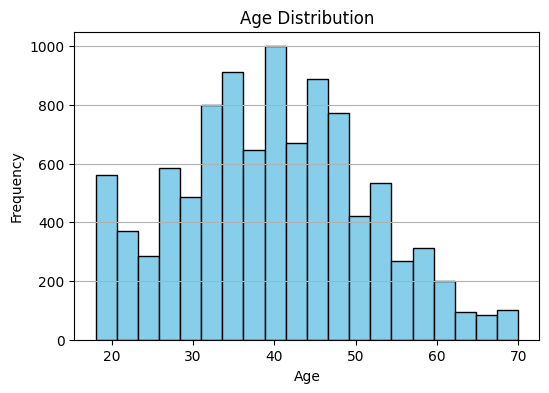

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(customers['age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

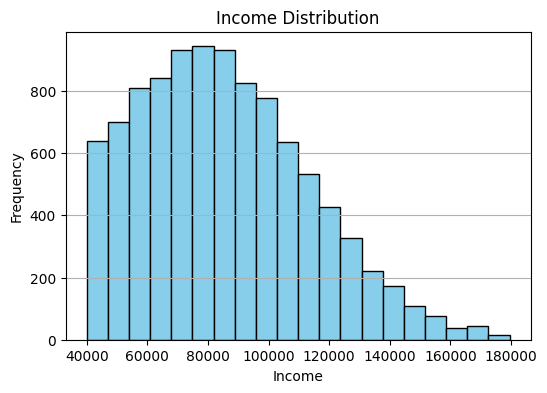

In [8]:
plt.figure(figsize=(6, 4))
plt.hist(customers['income'], bins=20, color='skyblue', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

#### Preprocess data

In [9]:
# Preprocess data for LSTM input
le_marital = LabelEncoder()
customers['marital_status_enc'] = le_marital.fit_transform(customers['marital_status'])
le_channel = LabelEncoder()
touchpoints['channel_enc'] = le_channel.fit_transform(touchpoints['channel'])
le_campaign = LabelEncoder()
touchpoints['campaign_enc'] = le_campaign.fit_transform(touchpoints['campaign'])

# Prepare sequences in 3-dimensional NumPy array
X_seq = np.zeros((data_size, max_touchpoints, 2), dtype=int)
for user_id, group in touchpoints.groupby('user_id'):
    for i, row in enumerate(group.sort_values('tp_order').itertuples()):
        if i < max_touchpoints:
            X_seq[user_id, i, 0] = row.channel_enc
            X_seq[user_id, i, 1] = row.campaign_enc

# Prepare customer features
scaler = StandardScaler()
X_cust = scaler.fit_transform(customers[['age', 'income', 'marital_status_enc']])
y = customers['conversion'].values

# third dimension is [channel, campaign], as integers
X_channel = X_seq[:, :, 0]
X_campaign = X_seq[:, :, 1]

#### Train Model

In [10]:
# Hyperparameters (optimized from experiments)
# Best configuration from smooth learning experiments:
lstm_units = 128  # Complex model for gradual learning
embedding_dim = 4
epochs = 30
learning_rate = 0.0005  # Lower learning rate for smoother curves
batch_size = 64  # Optimal from batch size experiments
patience = 10  # Higher patience for more training
validation_split = 0.1  # More data for training

In [ ]:
def create_optimized_model():
    """Create LSTM model with optimized parameters for smoother learning"""
    channel_input = Input(shape=(max_touchpoints,), dtype='int32', name='channel_input')
    campaign_input = Input(shape=(max_touchpoints,), dtype='int32', name='campaign_input')
    input_cust = Input(shape=(3,), name='customer_features')
    
    channel_emb = Embedding(num_channels, embedding_dim, mask_zero=False)(channel_input)
    campaign_emb = Embedding(num_campaigns, embedding_dim, mask_zero=False)(campaign_input)
    
    x = Concatenate()([channel_emb, campaign_emb])
    lstm_out = LSTM(lstm_units)(x)
    
    x = Concatenate()([lstm_out, input_cust])
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[channel_input, campaign_input, input_cust], outputs=output)
    
    # Use optimized learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'precision', Recall()])
    return model

# Create and train the optimized model
print("Training optimized LSTM model...")
model = create_optimized_model()

# Early stopping with optimized patience
es = EarlyStopping(patience=patience, restore_best_weights=True, verbose=1)

# Train model with optimized parameters
history = model.fit(
    [X_channel, X_campaign, X_cust], y,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    callbacks=[es],
    verbose=1
)

# Save the optimized model
model.save('lstm_attribution_model_optimized.h5')
print('Optimized model saved as lstm_attribution_model_optimized.h5')

Training optimized LSTM model...
Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9182 - loss: 0.2654 - precision: 0.9539 - recall: 0.9606 - val_accuracy: 0.9530 - val_loss: 0.1956 - val_precision: 0.9530 - val_recall: 1.0000
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9182 - loss: 0.2654 - precision: 0.9539 - recall: 0.9606 - val_accuracy: 0.9530 - val_loss: 0.1956 - val_precision: 0.9530 - val_recall: 1.0000
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9536 - loss: 0.1929 - precision: 0.9536 - recall: 1.0000 - val_accuracy: 0.9530 - val_loss: 0.1931 - val_precision: 0.9530 - val_recall: 1.0000
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9536 - loss: 0.1929 - precision: 0.9536 - recall: 1.0000 - val_accuracy: 0.9530 - val_loss: 0.1931 - val_precision: 0.9530 - val_recall: 1.0000
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9536 - loss: 0.1914 - precision: 0.9536 - recall: 1.0000 - va

Optimized model saved as lstm_attribution_model_optimized.h5


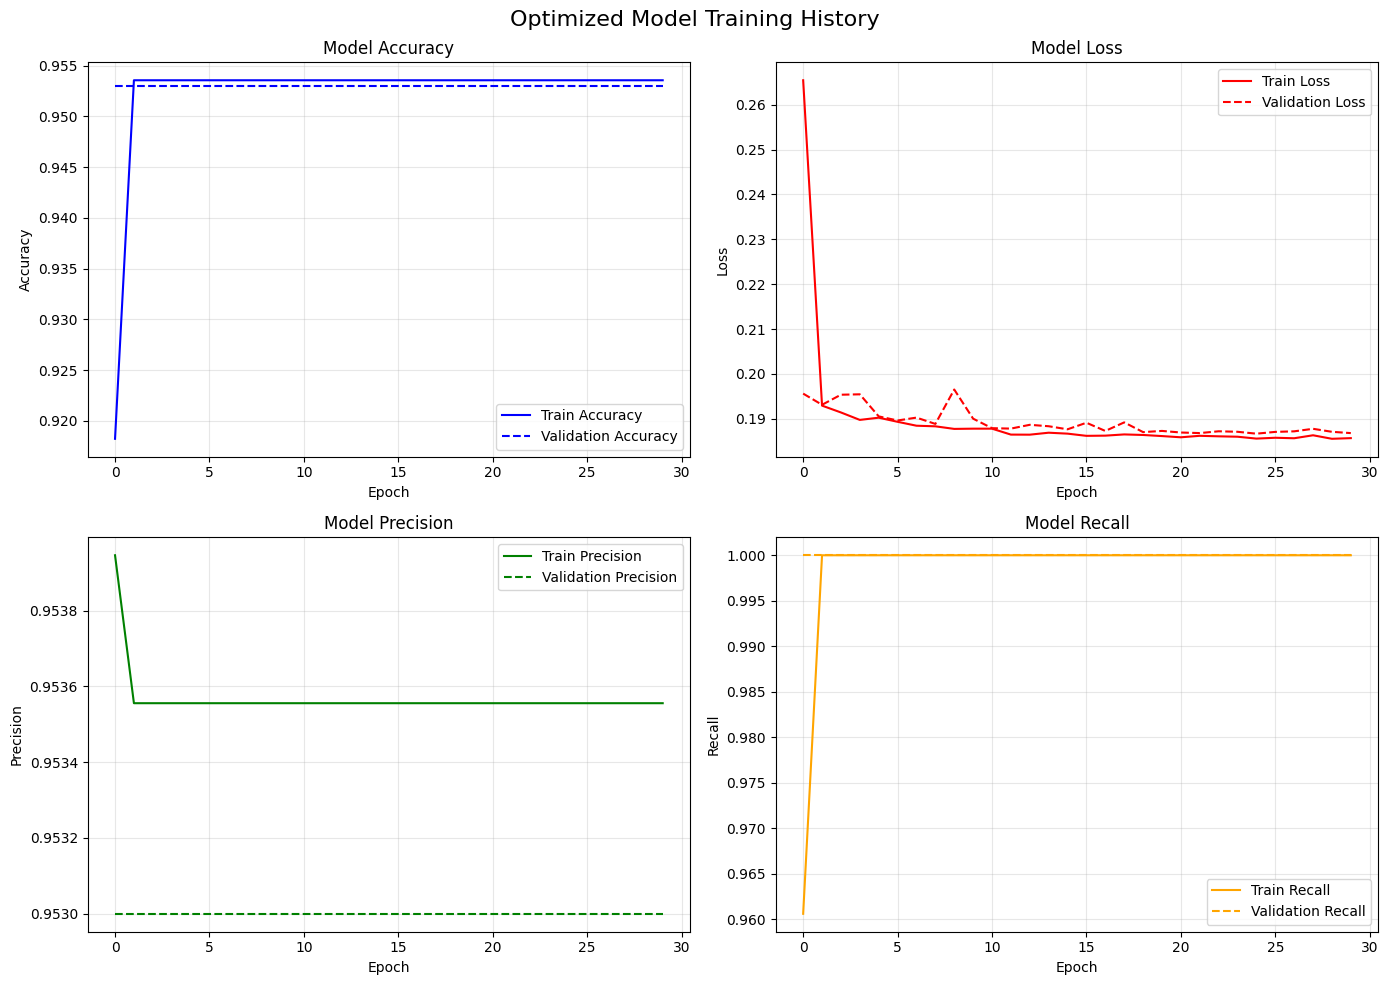


Final Model Performance:
Epochs Trained: 30
Final Validation Accuracy: 0.9530
Final Validation Loss: 0.1868


In [12]:
# Plot Training History
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Optimized Model Training History', fontsize=16)

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss', color='red')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Train Precision', color='green')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', color='green', linestyle='--')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Recall
recall_key = 'recall_1' if 'recall_1' in history.history else 'recall'
if recall_key in history.history:
    axes[1, 1].plot(history.history[recall_key], label='Train Recall', color='orange')
    val_recall_key = f'val_{recall_key}'
    if val_recall_key in history.history:
        axes[1, 1].plot(history.history[val_recall_key], label='Validation Recall', color='orange', linestyle='--')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final performance
final_val_acc = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
epochs_trained = len(history.history['loss'])

print(f"\nFinal Model Performance:")
print(f"Epochs Trained: {epochs_trained}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Create mappings for beam search
channel_to_idx = {ch: i for i, ch in enumerate(channels)}
idx_to_channel = {i: ch for i, ch in enumerate(channels)}
campaign_to_idx = {c: i for i, c in enumerate(campaigns)}
idx_to_campaign = {i: c for i, c in enumerate(campaigns)}

#### Experimental Notes

The current model parameters were optimized through systematic experiments:

- Default (LR=0.001, 32 units): Fast convergence, less smooth curves
- Lower LR (LR=0.0005, 32 units): Smoother learning
- Much Lower LR (LR=0.0001, 64 units): Very smooth curves
- **Complex Model (LR=0.0005, 128 units): Best balance** ✓

**Key Findings:**
- Lower learning rates (0.0005) create smoother training curves
- Higher LSTM units (128) allow for more gradual learning
- Increased patience (10) prevents premature stopping
- Smaller validation split (10%) provides more training data

#### Channel Path & Campaign Path Beam Search

In [13]:
# use stochastic sampling for campaign selection, but deterministic for channel selection
def beam_search_start_channel_with_campaign(model, customer_features, start_channel_name, start_campaign_idx, num_channels, num_campaigns, max_touchpoints, beam_width=5, temperature=1.0, campaign_sample_topk=3):
    if isinstance(start_channel_name, int):
        start_idx = start_channel_name
    else:
        start_idx = channel_to_idx[start_channel_name]
    beams = [([start_idx], [start_campaign_idx], 0)]  # (channels, campaigns, log_prob)
    seen_channel_seqs = set() # Track unique channel sequences
    for t in range(1, max_touchpoints):
        candidates = []
        for ch_seq, camp_seq, log_prob in beams:
            for ch in range(num_channels):
                # For each channel, consider all campaigns, but sample campaigns stochastically
                camp_probs = []
                for camp in range(num_campaigns):
                    new_ch_seq = ch_seq + [ch]
                    new_camp_seq = camp_seq + [camp]
                    # Enforce constraints: no more than 2 of same channel or campaign
                    if max([new_ch_seq.count(x) for x in set(new_ch_seq)]) > 2:
                        continue
                    if max([new_camp_seq.count(x) for x in set(new_camp_seq)]) > 2:
                        continue
                    ch_seq_tuple = tuple(new_ch_seq)
                    if ch_seq_tuple in seen_channel_seqs:
                        continue
                    ch_arr = np.array([new_ch_seq + [0]*(max_touchpoints-len(new_ch_seq))])
                    camp_arr = np.array([new_camp_seq + [0]*(max_touchpoints-len(new_camp_seq))])
                    prob = model.predict([ch_arr, camp_arr, customer_features], verbose=0)[0,0]
                    prob = np.exp(np.log(prob + 1e-8) / temperature)
                    camp_probs.append((camp, new_ch_seq, new_camp_seq, log_prob + np.log(prob + 1e-8)))
                # Sample campaigns for this channel based on their probabilities
                if camp_probs:
                    # Sort by log-prob, take top-k, then sample from them
                    camp_probs.sort(key=lambda x: x[3], reverse=True)
                    topk = camp_probs[:campaign_sample_topk] if len(camp_probs) > campaign_sample_topk else camp_probs
                    # Convert log-probs to probabilities for sampling
                    logprobs = np.array([x[3] for x in topk])
                    probs = np.exp(logprobs - np.max(logprobs))
                    probs = probs / probs.sum()
                    # Sample one or more campaigns (up to beam_width per channel)
                    sampled_idxs = np.random.choice(len(topk), size=min(beam_width, len(topk)), replace=False, p=probs)
                    for idx in sampled_idxs:
                        camp, new_ch_seq, new_camp_seq, new_log_prob = topk[idx]
                        ch_seq_tuple = tuple(new_ch_seq)
                        if ch_seq_tuple in seen_channel_seqs:
                            continue
                        seen_channel_seqs.add(ch_seq_tuple)
                        candidates.append((new_ch_seq, new_camp_seq, new_log_prob))
        # After all channels, keep top beam_width overall
        candidates.sort(key=lambda x: x[2], reverse=True)
        beams = candidates[:beam_width]
    return [((ch, camp), score) for ch, camp, score in beams]

In [14]:
# Title widget for the UI
title_widget = widgets.HTML('<h1 style="text-align:center; margin-bottom: 20px;">Multi-Touch Customer Optimization Tool</h1>')

def update_paths(start_channel, start_campaign, age, income, marital_status, temperature):
    # Encode marital status using the same encoder as in preprocessing
    marital_status_enc = le_marital.transform([marital_status])[0] if hasattr(le_marital, 'classes_') else 1
    customer_features = np.array([[age, income, marital_status_enc]])
    customer_features_scaled = scaler.transform(customer_features)
    if isinstance(start_campaign, int):
        start_campaign_idx = start_campaign
    else:
        start_campaign_idx = campaign_to_idx[start_campaign]
    results = beam_search_start_channel_with_campaign(model, customer_features_scaled, start_channel, start_campaign_idx, num_channels, num_campaigns, max_touchpoints, beam_width=3, temperature=temperature)
    clear_output(wait=True)
    # Print best paths with reduced font size for readability
    html = f'<div style="font-size:12px; font-family:monospace; margin-bottom:10px;">Best paths starting from <b>{start_channel}</b> / <b>{start_campaign}</b> for Age=<b>{age}</b>, Income=<b>{income}</b>, Marital Status=<b>{marital_status}</b>, Temperature=<b>{temperature}</b>:'
    for (ch_seq, camp_seq), score in results:
        html += f'<br>Channels: {[idx_to_channel[i] for i in ch_seq]}, Campaigns: {[idx_to_campaign[i] for i in camp_seq]}, Log-Prob: {score:.4f}'
    html += '</div>'
    display(HTML(html))
    # Side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)
    for i, ((ch_seq, camp_seq), score) in enumerate(results):
        ax1.plot(range(len(ch_seq)), ch_seq, marker='o', label=f'Path {i+1} (log-prob={score:.2f})')
        ax2.plot(range(len(camp_seq)), camp_seq, marker='s', label=f'Path {i+1} (log-prob={score:.2f})')
    ax1.set_xticks(range(max_touchpoints))
    ax1.set_yticks(range(num_channels))
    ax1.set_yticklabels([idx_to_channel[i] for i in range(num_channels)])
    ax1.set_ylabel('Channel')
    ax1.set_xlabel('Touchpoint Order')
    ax1.set_title(f'Best Channel Paths Starting from {start_channel}')
    ax1.legend()
    ax2.set_xticks(range(max_touchpoints))
    ax2.set_yticks(range(num_campaigns))
    ax2.set_yticklabels([idx_to_campaign[i] for i in range(num_campaigns)])
    ax2.set_xlabel('Touchpoint Order')
    ax2.set_ylabel('Campaign')
    ax2.set_title('Campaign Paths for Each Beam')
    ax2.legend()
    plt.tight_layout()
    plt.show()

style = {'description_width': 'initial'}
channel_selector = widgets.Dropdown(options=channels, value=channels[0], description='Starting Channel:', style=style)
campaign_selector = widgets.Dropdown(options=campaigns, value=campaigns[0], description='Starting Campaign:', style=style)
marital_status_selector = widgets.Dropdown(options=le_marital.classes_ if hasattr(le_marital, 'classes_') else ['single','married','divorced'], value='married', description='Marital Status:', style=style)
age_slider = widgets.IntSlider(value=45, min=18, max=70, step=1, description='Customer Age:', style=style)
income_slider = widgets.IntSlider(value=70000, min=20000, max=200000, step=1000, description='Customer Income:', style=style)
temperature_slider = widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='Temperature:', style=style)
ui = widgets.VBox([title_widget, channel_selector, campaign_selector,  marital_status_selector, age_slider, income_slider, temperature_slider])
out = widgets.interactive_output(update_paths, {'start_channel': channel_selector, 'start_campaign': campaign_selector, 'marital_status': marital_status_selector, 'age': age_slider, 'income': income_slider, 'temperature': temperature_slider})
display(ui, out)

Output()